# Goals

* Create a tiledb-soma db for the Tahoe-100 dataset
* Description of the [metadata](https://docs.google.com/spreadsheets/d/18lu5agCNbgWsjZ9K05Mf65z1RseoFqsi/edit?usp=sharing&ouid=103963277960448548043&rtpof=true&sd=true)

# Vars

In [1]:
work_dir = '/processed_datasets/scRecount/tahoe'

# Init

In [2]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import scanpy as sc
import numpy as np
import plotnine as pn
import pyarrow as pa
import pyarrow.compute as pc
from typing import Optional, List

In [3]:
pn.theme_set(pn.theme_bw())

In [5]:
db_uri = os.path.join(work_dir, 'tiledb-soma')
#db_uri = os.path.join(work_dir, 'tiledb-soma-mini')
#db_uri = "gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/"
db_uri

'/processed_datasets/scRecount/tahoe/tiledb-soma'

# Create

In [37]:
# list all *.h5ad.gz files in the work directory
files = sorted(glob(os.path.join(work_dir, '*.h5ad.gz')))
files

['/processed_datasets/scRecount/tahoe/plate10_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate11_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate12_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate13_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate14_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate1_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate2_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate4_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate5_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate6_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate7_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate8_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate9_filtered.h5ad.gz']

> Ran via tmux to prevent disconnection

```bash
./scripts/tiledb-loader-tahoe.py \
  --h5ad-ext h5ad.gz \
  --db-uri /processed_datasets/scRecount/tahoe/tiledb-soma \
  /processed_datasets/scRecount/tahoe/ \
  > tiledb-loader-tahoe.log 2>&1 
```

# Summary

In [ ]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
BARCODE_SUB_LIB_ID: large_string
sample: dictionary<values=string, indices=int32, ordered=0>
species: dictionary<values=string, indices=int32, ordered=0>
gene_count: int64
tscp_count: int64
mread_count: int64
bc1_wind: int64
bc2_wind: int64
bc3_wind: int64
bc1_well: dictionary<values=string, indices=int32, ordered=0>
bc2_well: dictionary<values=string, indices=int32, ordered=0>
bc3_well: dictionary<values=string, indices=int32, ordered=0>
id: dictionary<values=string, indices=int32, ordered=0>
drugname_drugconc: dictionary<values=string, indices=int32, ordered=0>
drug: dictionary<values=string, indices=int32, ordered=0>
INT_ID: double
NUM.SNPS: double
NUM.READS: double
demuxlet_call: dictionary<values=string, indices=int32, ordered=0>
BEST.GUESS: dictionary<values=string, indices=int32, ordered=0>
BEST.LLK: double
NEXT.GUESS: dictionary<values=string, indices=int32, ordered=0>
NEXT.LLK: double
DIFF.LLK.BEST.NEXT: double
BEST.POSTERIOR: double
SNG.POSTERIOR: 

## Obs

In [9]:
def get_obs(
        db_uri: str,
        columns: Optional[List[str]] = None,
        obs_query: Optional[tiledbsoma.AxisQuery] = None,
        axis: str = "RNA",
        group_by: Optional[List[str]] = None,
        agg_name: str = "count_all"
    ) -> pd.DataFrame:
    """
    Retrieve the obs table from a tiledbsoma Experiment.
    
    If group_by is provided, aggregated counts by the specified grouping columns are returned.
    Otherwise, the full obs subset with the specified columns is returned.
    
    Parameters:
      db_uri: URI for the database.
      columns: List of column names to retrieve (required if group_by is None).
      obs_query: Optional AxisQuery to filter the obs data.
      axis: The axis to query (default "RNA").
      group_by: Optional list of columns to group by for aggregation.
      agg_name: Name for the aggregated count column (default "count_all").
    
    Returns:
      A pandas DataFrame containing either the subset of obs data or the aggregated counts.
    """
    if group_by is not None:
        # When grouping, we only need the group_by columns.
        group_cols = group_by
        chunk_results: List[pd.DataFrame] = []
        with tiledbsoma.Experiment.open(db_uri) as exp:
            # Use axis_query if provided.
            if obs_query is not None:
                try:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs(column_names=group_cols)
                except TypeError:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs()
                chunk_iter = reader
            else:
                chunk_iter = exp.obs.read(column_names=group_cols)
            # Process each chunk.
            for chunk in chunk_iter:
                if chunk.num_rows == 0:
                    continue
                df_chunk = chunk.to_pandas()
                # Group and count within this chunk.
                df_group = df_chunk.groupby(group_cols, as_index=False).size().rename(columns={"size": agg_name})
                chunk_results.append(df_group)
        if not chunk_results:
            return pd.DataFrame(columns=group_cols + [agg_name])
        # Combine chunk results and re-aggregate to get overall counts.
        df_all = pd.concat(chunk_results, ignore_index=True)
        df_final = df_all.groupby(group_cols, as_index=False)[agg_name].sum()
        return df_final.sort_values(by=agg_name, ascending=False)
    else:
        # Without grouping, ensure columns is provided.
        if columns is None:
            raise ValueError("When group_by is not specified, the 'columns' parameter must be provided.")
        chunks: List[pd.DataFrame] = []
        with tiledbsoma.Experiment.open(db_uri) as exp:
            if obs_query is not None:
                try:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs(column_names=columns)
                except TypeError:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs()
                chunk_iter = reader
            else:
                chunk_iter = exp.obs.read(column_names=columns)
            for chunk in chunk_iter:
                if chunk.num_rows == 0:
                    continue
                df_chunk = chunk.to_pandas()[columns]
                chunks.append(df_chunk)
        if not chunks:
            return pd.DataFrame(columns=columns)
        return pd.concat(chunks, ignore_index=True)


In [45]:
# def aggregate_obs_counts(db_uri: str, group_columns: list[str]=["sample", "species"], agg_name: str="count_all") -> pd.DataFrame:
#     # List to store per‑chunk aggregated DataFrames.
#     chunk_results: list[pd.DataFrame] = []
#     with tiledbsoma.Experiment.open(db_uri) as exp:
#         # Process each chunk separately.
#         for chunk in exp.obs.read(column_names=group_columns):
#             if chunk.num_rows == 0:
#                 continue
#             # Convert the chunk to a pandas DataFrame.
#             df_chunk = chunk.to_pandas()
#             # Compute the counts per group in this chunk.
#             df_group = df_chunk.groupby(group_columns, as_index=False).size().rename(columns={"size": agg_name})
#             chunk_results.append(df_group)
#     # If no data was processed, return an empty DataFrame.
#     if not chunk_results:
#         return pd.DataFrame(columns=group_columns + [agg_name])
#     # Concatenate per-chunk results.
#     df_all = pd.concat(chunk_results)
#     # Re-group to combine counts from different chunks.
#     df_final = df_all.groupby(group_columns, as_index=False)[agg_name].sum()
#     # Return sorted result.
#     return df_final.sort_values(by=agg_name, ascending=False)

In [46]:
# # Example usage:
# counts = aggregate_obs_counts(db_uri, group_columns=["sample"])
# print(counts.shape)
# counts.head()

In [47]:
# obs per sample
# sample_counts = {}
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     for obs_table in exp.obs.read(column_names=["sample"]):
#         if obs_table.num_rows == 0:
#             continue

#         result = pc.value_counts(obs_table["sample"])
#         unique_samples = result.field('values')
#         counts = result.field('counts')

#         for sample, count in zip(unique_samples.to_pylist(), counts.to_pylist()):
#             sample_counts[sample] = sample_counts.get(sample, 0) + count

# df = pd.DataFrame(list(sample_counts.items()), columns=["sample", "count_all"])
# df = df.sort_values(by="count_all", ascending=False)

# print(df.shape)
# df.head()

In [48]:
# obs per sample
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['sample'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.head()

In [12]:
# total obs
df["count_all"].sum()

100648790

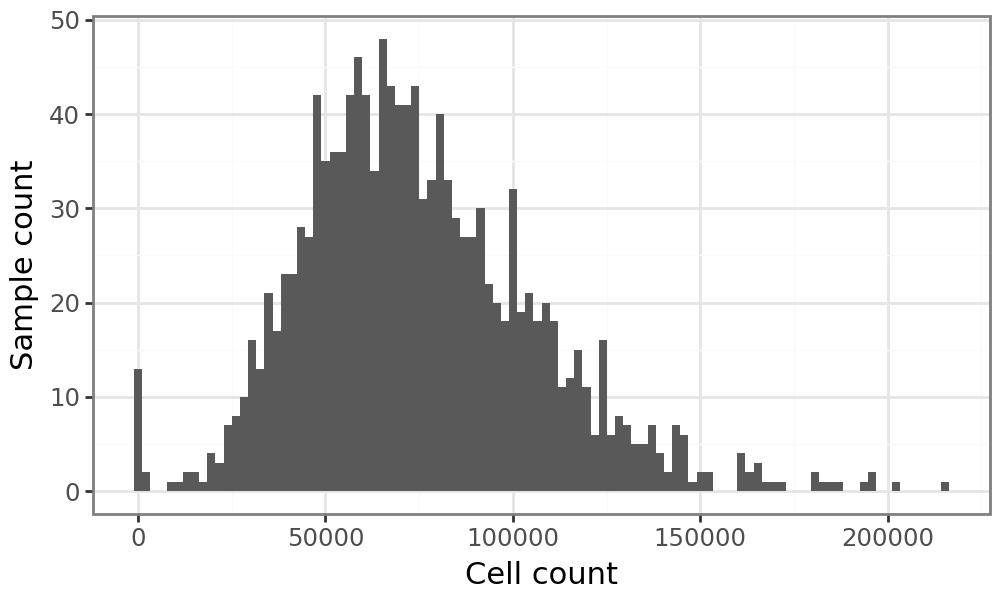

In [13]:
# plot cells per sample
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cell count", y="Sample count") +
    pn.theme(figure_size=(5,3))
    )
p

In [13]:
# # cells per sample & species
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["sample", "species"])
#         .concat()
#         .group_by(["sample", "species"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

In [14]:
# # cells per drug
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["drug"])
#         .concat()
#         .group_by(["drug"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

counts = get_obs(db_uri, group_by=["drug"])
print(counts.shape)
counts.head()

/tmp/ipykernel_839920/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


(380, 2)


/tmp/ipykernel_839920/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,drug,count_all
28,DMSO_TF,2330156
4,Adagrasib,1504078
104,Afatinib,734761
187,Almonertinib (mesylate),622410
114,Binimetinib,574740


In [15]:
# add total count by drug
top_drugs = counts.sort_values('count_all', ascending=False)["drug"].unique()[:30]
df = counts[counts["drug"].isin(top_drugs)]
df

,drug,count_all
28,DMSO_TF,2330156
4,Adagrasib,1504078
104,Afatinib,734761
187,Almonertinib (mesylate),622410
114,Binimetinib,574740
225,Fumaric acid,574017
203,Cytarabine,569615
252,Pravastatin (sodium),569466
191,Belumosudil,553774
194,Berbamine (dihydrochloride),540485


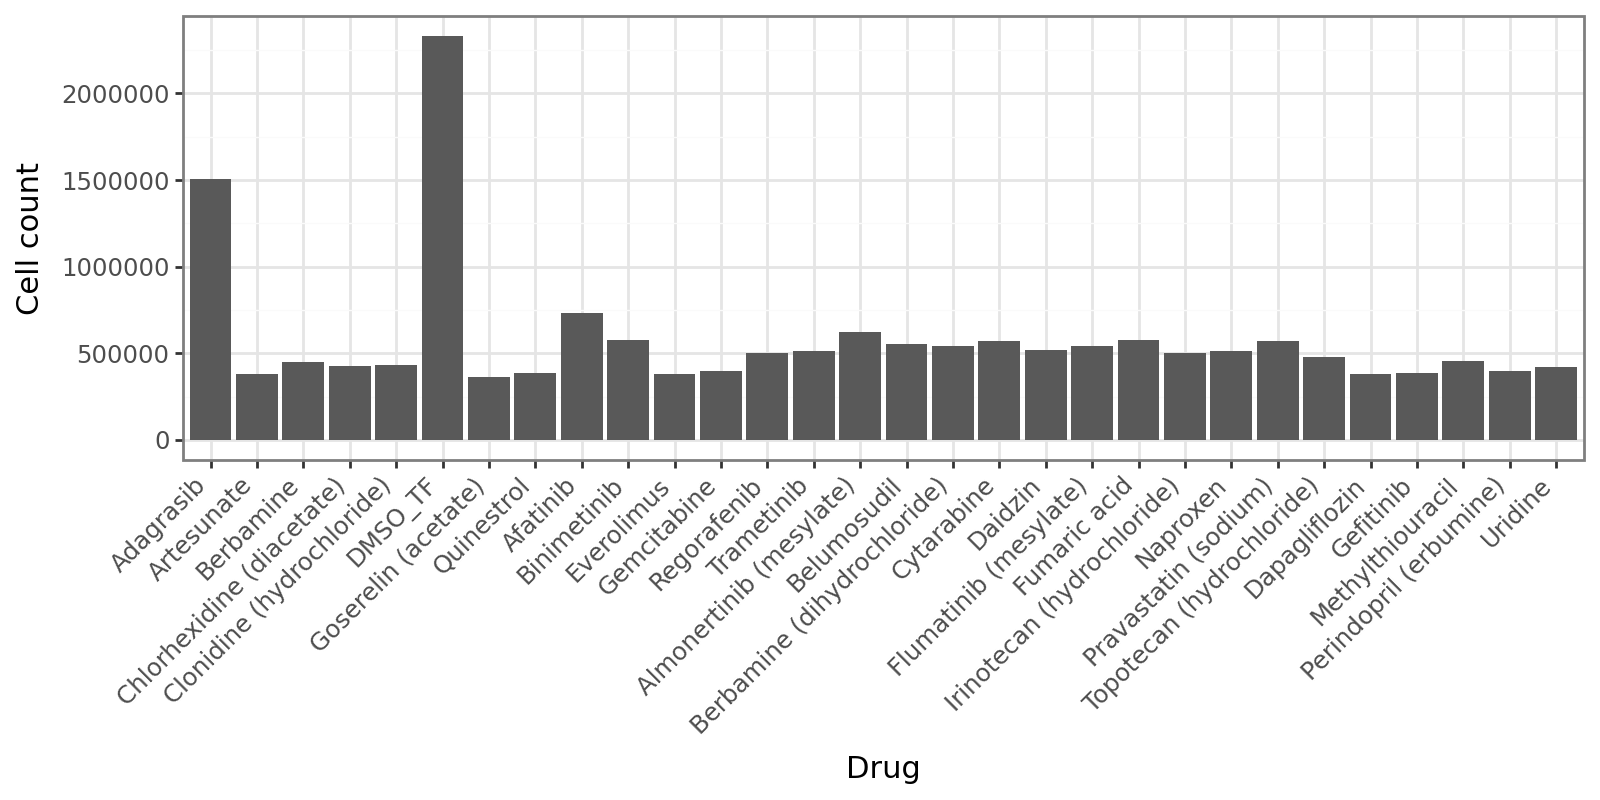

In [16]:
# plot cells per drug
counts['drug'] = pd.Categorical(counts['drug'], categories=counts.sort_values('count_all', ascending=False)['drug'].unique().tolist(), ordered=True)
p = (
    pn.ggplot(df, pn.aes(x="drug", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(8,4),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

In [17]:
# cells per drug and cell name
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["drug", "cell_name"])
#         .concat()
#         .group_by(["drug", "cell_name"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

# cells per drug and cell name
counts = get_obs(db_uri, group_by=["drug", "cell_name"])
print(counts.shape)
counts.head()

/tmp/ipykernel_839920/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


(19000, 3)


/tmp/ipykernel_839920/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,drug,cell_name,count_all
1448,DMSO_TF,SW480,147988
1432,DMSO_TF,NCI-H460,131593
248,Adagrasib,SW480,97814
1435,DMSO_TF,PANC-1,97098
232,Adagrasib,NCI-H460,88031


In [18]:
# add total count by drug
counts["total_count"] = counts.groupby("drug")["count_all"].transform("sum")
top_drugs = counts.sort_values('total_count', ascending=False)["drug"].unique()[:10]
counts = counts[counts["drug"].isin(top_drugs)]
counts

/tmp/ipykernel_839920/3380186392.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,drug,cell_name,count_all,total_count
1448,DMSO_TF,SW480,147988,2330156
1432,DMSO_TF,NCI-H460,131593,2330156
248,Adagrasib,SW480,97814,1504078
1435,DMSO_TF,PANC-1,97098,2330156
232,Adagrasib,NCI-H460,88031,1504078
...,...,...,...,...
9383,Almonertinib (mesylate),NCI-H596,170,622410
11283,Fumaric acid,NCI-H596,163,574017
9733,Berbamine (dihydrochloride),NCI-H596,163,540485
5733,Binimetinib,NCI-H596,155,574740


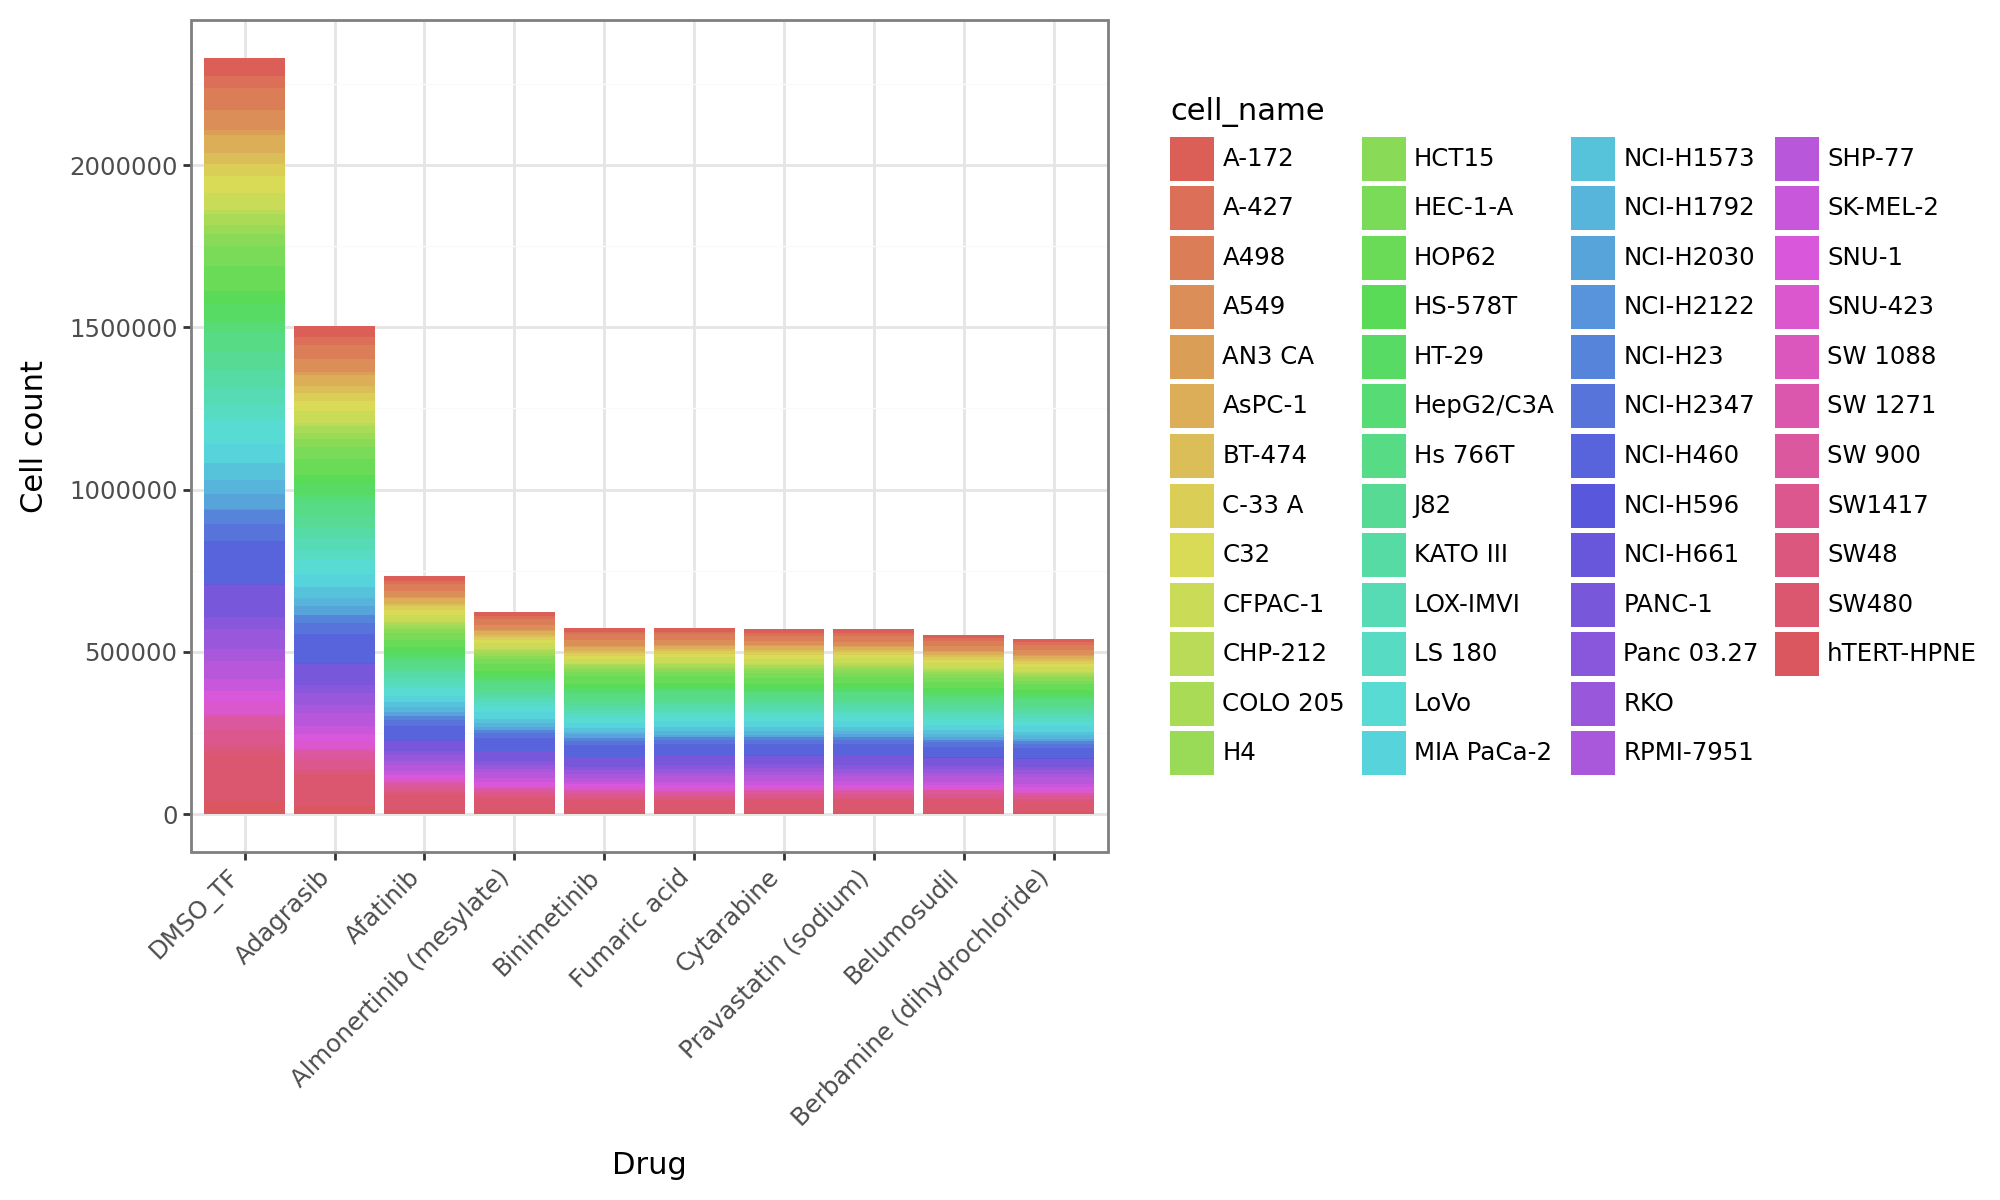

In [19]:
# plot cells per drug
counts['drug'] = pd.Categorical(counts['drug'], categories=counts.sort_values('total_count', ascending=False)['drug'].unique().tolist(), ordered=True)
p = (
    pn.ggplot(counts, pn.aes(x="drug", y="count_all", fill="cell_name")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(10,6),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

In [22]:
# cells per cell line/name
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["cell_line", "cell_name"])
#         .concat()
#         .group_by(["cell_line", "cell_name"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

In [23]:
# cells per cell line/name
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["cell_line", "cell_name", "drug"])
#         .concat()
#         .group_by(["cell_line", "cell_name", "drug"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

In [20]:
# cells per phase
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["phase"])
#         .concat()
#         .group_by(["phase"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

In [21]:
# cells per pass_filter
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["pass_filter"])
#         .concat()
#         .group_by(["pass_filter"])
#         .aggregate([
#             ([], 'count_all'),
#         ])
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

### Transcripts

In [20]:
# def get_obs(db_uri: str, columns: list[str]) -> pd.DataFrame:
#     # List to accumulate DataFrame chunks.
#     chunks: list[pd.DataFrame] = []
#     # Open the SOMA experiment.
#     with tiledbsoma.Experiment.open(db_uri) as exp:
#         # Iterate over chunks of the obs table, reading only the specified columns.
#         for chunk in exp.obs.read(column_names=columns):
#             if chunk.num_rows == 0:
#                 continue
#             # Convert the current chunk to a pandas DataFrame.
#             df_chunk = chunk.to_pandas()
#             chunks.append(df_chunk)
#     # Concatenate all chunks into a single DataFrame.
#     if not chunks:
#         return pd.DataFrame(columns=columns)
#     return pd.concat(chunks, ignore_index=True)

# # Example usage: Return only the "sample" and "species" columns.
# df = get_obs(db_uri, columns=["sample", "tscp_count"])
# print(df.shape)
# df.head()

In [21]:
# # transcripts per cell
# with tiledbsoma.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["tscp_count"])
#         .concat()
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

In [22]:
# transcripts per cell
counts = get_obs(db_uri, group_by=["tscp_count"])
print(counts.shape)
counts.head()

(47042, 2)


,tscp_count,count_all
1071,1232,46791
1046,1207,46706
1068,1229,46680
1063,1224,46676
1125,1286,46636


In [24]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["tscp_count"].describe())

count    47042
mean     25206
std      16595
min        161
25%      11921
50%      23682
75%      35766
max     235188
Name: tscp_count, dtype: float64


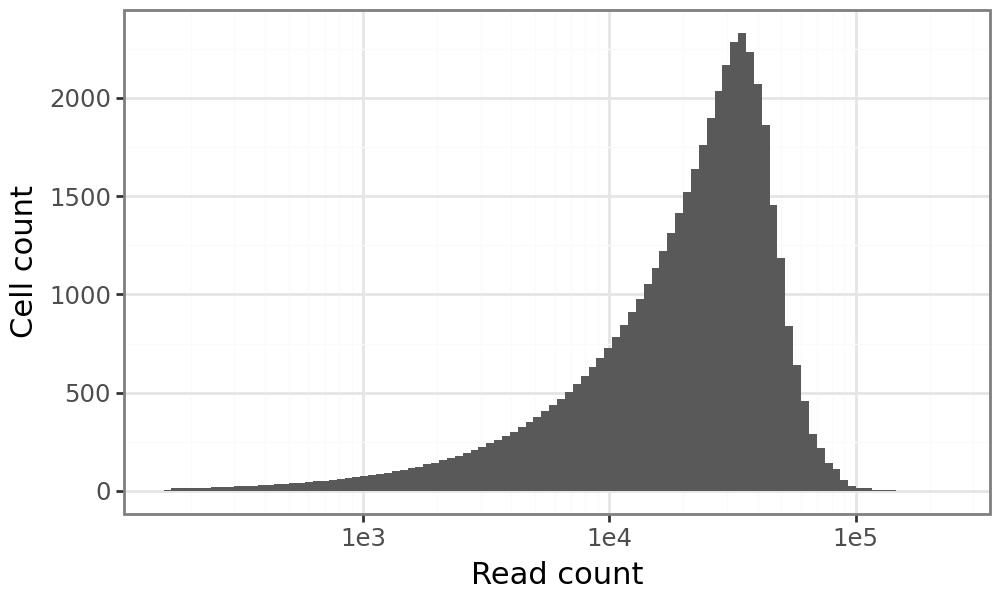

In [25]:
# plot transcripts per cell (barcode)
p = (
    pn.ggplot(counts, pn.aes(x="tscp_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Read count", y="Cell count") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

In [27]:
# # gene count per cell
# with tiledbsoma.Experiment.open(db_uri) as exp:
#     df = (
#         exp.obs.read(column_names=["gene_count"])
#         .concat()
#         .to_pandas()
#     )
# print(df.shape)
# df.head()

# Example usage: Return only the "sample" and "species" columns.
counts = get_obs(db_uri, columns=["gene_count"])
print(counts.shape)
counts.head()

(100648790, 1)


,gene_count
0,1154
1,1132
2,916
3,1857
4,731


In [28]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["gene_count"].describe())

count   100648790
mean         1451
std           812
min           115
25%           898
50%          1255
75%          1776
max         14153
Name: gene_count, dtype: float64


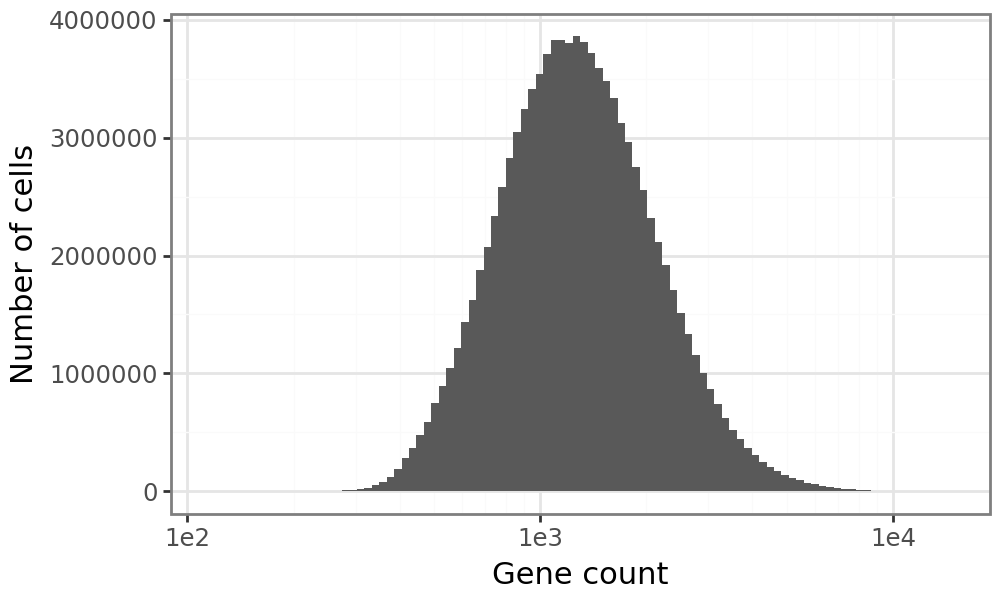

In [29]:
# plot reads per gene (barcode)
p = (
    pn.ggplot(counts, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Gene count", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

### Queries

In [31]:
# Example usage:
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743"]')
df = get_obs(db_uri, columns=["sample"], obs_query=obs_query)
print(df.shape)
df.head()

(56390, 1)


,sample
0,smp_2743
1,smp_2743
2,smp_2743
3,smp_2743
4,smp_2743


## Variables

In [32]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.ms["RNA"].var.schema)

soma_joinid: int64 not null
gene_name: large_string
var_id: large_string
organism: large_string


In [33]:
# read in the var level data
with tiledbsoma.Experiment.open(db_uri) as exp:
    df_var = (
        exp.ms["RNA"]
        .var.read()
        .concat()
        .to_pandas()
    )
df_var

,soma_joinid,gene_name,var_id,organism
0,0,TSPAN6,ENSG00000000003,Homo_sapiens
1,1,TNMD,ENSG00000000005,Homo_sapiens
2,2,DPM1,ENSG00000000419,Homo_sapiens
3,3,SCYL3,ENSG00000000457,Homo_sapiens
4,4,C1orf112,ENSG00000000460,Homo_sapiens
...,...,...,...,...
62705,62705,ENSG00000291313,ENSG00000291313,Homo_sapiens
62706,62706,ENSG00000291314,ENSG00000291314,Homo_sapiens
62707,62707,ENSG00000291315,ENSG00000291315,Homo_sapiens
62708,62708,ENSG00000291316,ENSG00000291316,Homo_sapiens


### Add `var_id` column

 - Ensembl gene ids

In [18]:
# dataframe provided by Richard from Vevo
df_vevo_var = pd.read_csv("data/2025-02-14_vevo_tahoe-100_anndata_var.csv").rename(columns={"gene_id": "var_id"})
df_vevo_var

,gene_name,var_id,genome
0,TSPAN6,ENSG00000000003,hg38
1,TNMD,ENSG00000000005,hg38
2,DPM1,ENSG00000000419,hg38
3,SCYL3,ENSG00000000457,hg38
4,C1orf112,ENSG00000000460,hg38
...,...,...,...
62705,ENSG00000291313,ENSG00000291313,hg38
62706,ENSG00000291314,ENSG00000291314,hg38
62707,ENSG00000291315,ENSG00000291315,hg38
62708,ENSG00000291316,ENSG00000291316,hg38


In [20]:
pd.merge(df_var, df_vevo_var, on="gene_name", how="inner")

,soma_joinid,gene_name,var_id_x,var_id_y,genome
0,0,TSPAN6,TSPAN6,ENSG00000000003,hg38
1,1,TNMD,TNMD,ENSG00000000005,hg38
2,2,DPM1,DPM1,ENSG00000000419,hg38
3,3,SCYL3,SCYL3,ENSG00000000457,hg38
4,4,C1orf112,C1orf112,ENSG00000000460,hg38
...,...,...,...,...,...
62705,62705,ENSG00000291313,ENSG00000291313,ENSG00000291313,hg38
62706,62706,ENSG00000291314,ENSG00000291314,ENSG00000291314,hg38
62707,62707,ENSG00000291315,ENSG00000291315,ENSG00000291315,hg38
62708,62708,ENSG00000291316,ENSG00000291316,ENSG00000291316,hg38


In [25]:
# merge the two dataframes
df_var = pd.merge(df_var.drop(["var_id"], axis=1), df_vevo_var, on="gene_name", how="inner")[["soma_joinid", "var_id", "gene_name"]]
df_var["organism"] = "Homo_sapiens"
df_var

,soma_joinid,var_id,gene_name,organism
0,0,ENSG00000000003,TSPAN6,Homo_sapiens
1,1,ENSG00000000005,TNMD,Homo_sapiens
2,2,ENSG00000000419,DPM1,Homo_sapiens
3,3,ENSG00000000457,SCYL3,Homo_sapiens
4,4,ENSG00000000460,C1orf112,Homo_sapiens
...,...,...,...,...
62705,62705,ENSG00000291313,ENSG00000291313,Homo_sapiens
62706,62706,ENSG00000291314,ENSG00000291314,Homo_sapiens
62707,62707,ENSG00000291315,ENSG00000291315,Homo_sapiens
62708,62708,ENSG00000291316,ENSG00000291316,Homo_sapiens


In [26]:
# update database
with tiledbsoma.Experiment.open(db_uri, "w") as exp:
    tiledbsoma.io.update_var(exp, df_var, measurement_name="RNA")

## Copy to GCP

In [33]:
!gsutil -m rsync -r /processed_datasets/scRecount/tahoe/tiledb-soma/ gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/ > rsync.log 2>&1

# sessionInfo

In [82]:
!mamba list

# packages in environment at /home/nickyoungblut/miniforge3/envs/tiledb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiohappyeyeballs          2.4.4              pyhd8ed1ab_1    conda-forge
aiohttp                   3.11.11         py312h178313f_0    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
array-api-compat          1.10.0             pyhd8ed1ab_0    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
attrs                     25.1.0             pyh71513ae_0    conda-forge
aws-c-auth                0.8.1                h205f482_0    conda-forge
aws-c-cal                 0.8.1                h1a47875_3    conda-forge
aws-c-common              0.10.6               hb9d3cd8